<a href="https://colab.research.google.com/github/ImaginationX4/HybridZero/blob/main/BFS_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium

###1.Node


In [21]:
import math
import numpy as np
import torch
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional


@dataclass
class Node:
    state: np.ndarray
    action_taken: Optional[int] = None
    parent: Optional['Node'] = None
    children: dict = field(default_factory=dict)
    #visit_count: int = 0
    value: float = 0.0
    prior: float = 0.0
    depth: int = 0
    done: bool = False
    reward: float = 0.0
    visit_count: int = 1

    def __post_init__(self):
        if self.parent is not None:
            self.depth = self.parent.depth + 1

    def __hash__(self):
        return hash(self.state)

###2.Netork

In [2]:
from typing import List, Tuple, Optional
from queue import PriorityQueue
import gymnasium as gym

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from dataclasses import dataclass, field
from functools import lru_cache

# 神经网络模型定义
'''class HeuristicNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(4, 64),  # 4维输入
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)

        )

    def forward(self, state):
        x = self.embedding(state)
        return self.fc(x)'''
class HeuristicNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 共享特征提取层
        self.feature = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        # 策略头
        self.policy_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Softmax(dim=-1)
        )
        # 价值头
        self.value_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Tanh()
        )

    def forward(self, x, action=None):
        features = self.feature(x)
        policy = self.policy_head(features)
        value = self.value_head(features)

        return value.squeeze(),policy

###3.BFS

In [33]:
class BFS:
  def __init__(self, num_simulations: int = 10,
                 buffer_size: int = 10000, batch_size: int = 32):
    self.env = gym.make('CartPole-v1')
    self.env.reset()
    self.num_simulations = num_simulations
    self.model = HeuristicNetwork()
    self.target_model = HeuristicNetwork()
    self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
    self.loss_fn = nn.MSELoss()

     # 经验回放缓存
    self.replay_buffer = deque(maxlen=buffer_size)
    self.batch_size = batch_size

    # 目标网络同步间隔
    self.target_update_interval = 15
    self.train_step_counter = 0

    self._counter = 0

  def bfs_search(self,current_state):
    root = Node(current_state)

    queue = PriorityQueue()
    queue.put((0,self._counter, root))


    while not queue.empty():
      _,_, current_node = queue.get()
      #print('current_node__depth',current_node.depth)
      # 收集训练数据
      if current_node.depth > 500:
        print('++++++500++++')
        break
      if current_node.parent is not None:
        target, target_policy = self._get_bootstrap_target(current_node)
        self._remember(current_node.parent.state, target, target_policy)



      for action in range(self.env.action_space.n):
        #self.env.unwrapped.s = current_node.state

        #print('self.env.unwrapped.s ',self.env.unwrapped.s)
        #next_state, reward, done, _, _ = self.env.step(action)
        temp_env = gym.make('CartPole-v1')  # 创建临时环境
        temp_env.reset()
        temp_env.unwrapped.s = current_node.state  # 设置状态

        next_state, reward, done, _, _ = temp_env.step(action)

        next_node = Node(state=next_state, action_taken = action,parent = current_node,
                          reward=reward, done=done)
        #print('depth',next_node.depth)
        #print('action',action)
        current_node.children[action] = next_node
        if done:
          print('end++++')
          next_node.value = -10  # 给予负奖励
        else:
          # 神经网络预测
          with torch.no_grad():
              state_tensor = torch.FloatTensor(next_state)
              value, prior = self.model(state_tensor)
              next_node.value = value.item()
              next_node.prior = prior[action].item()

          #self._backpropagate(next_node)

          priority = -self._calculate_heuristic(next_node)
          self._counter += 1
          queue.put((priority,self._counter, next_node))
        #self.env.unwrapped.state = original_state
        if self._counter % 32 == 0:
          self._replay()

    best_action = max([0, 1],
          key=lambda a: root.children[a].value if a in root.children else -1)
    #print('root_kids',root.children)

    print('children,value[0]',root.children[1].value)
    print('children,value[1]',root.children[1].value)

    print('best_action',best_action)
    return best_action

  def _calculate_heuristic(self,node):

    P= node.prior
    Q= node.value
    # 在启发式函数中加入探索项
    c = 2.0  # 探索系数
    uct = Q/node.visit_count + c * P * np.sqrt(node.parent.visit_count) / (1 + node.visit_count)


    return uct

  def _get_bootstrap_target(self,node):
    next_state = node.state
    reward = node.reward
    gamma = 0.99
    with torch.no_grad():
      next_value, policy = self.target_model(torch.FloatTensor(next_state))
    return reward + gamma* next_value.item(), policy



  def _remember(self, state, target_value, target_policy):
    self.replay_buffer.append((state, target_value, target_policy))

  def _replay(self):
    """经验回放"""
    if len(self.replay_buffer) < self.batch_size:
        return

    batch = np.random.choice(len(self.replay_buffer), self.batch_size, replace=False)
    states, target_value, tartget_policy = zip(*[self.replay_buffer[i] for i in batch])

    self._update_network(states, target_value, tartget_policy)

  def _update_network(self, states, target_value, target_policy):

    states = torch.FloatTensor(states)
    target_value = torch.FloatTensor(target_value)
    target_policy = torch.FloatTensor(np.array(target_policy))


    predictions_value, predictions_policy = self.model(states)
    loss_value = self.loss_fn(predictions_value, target_value)
    loss_policy = nn.CrossEntropyLoss()(predictions_policy, target_policy.argmax(dim=1))  # ✅
    loss =  loss_value + loss_policy

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # 定期更新目标网络
    self.train_step_counter += 1
    if self.train_step_counter % self.target_update_interval == 0:
        self.target_model.load_state_dict(self.model.state_dict())

  def _backpropagate(self,node):
    # 可以添加奖励衰减
    gamma = 0.99
    current_value = node.value
    while node.parent is not None:
        node = node.parent
        node.value += current_value
        current_value *= gamma
        node.visit_count += 1
def train_agent():
  env = gym.make('CartPole-v1')
  agent = BFS()

  for episode in range(1):

      state = env.reset()[0]
      total_reward = 0
      done = False


      while not done:
          action = agent.bfs_search(state)
          next_state, reward, done, _, _ = env.step(action)
          total_reward += reward
          state = next_state

      print(f"Episode {episode+1}, Reward: {total_reward}")

if __name__ == "__main__":
    train_agent()

++++++500++++
children,value[0] 0.03558943048119545
children,value[1] 0.03558943048119545
best_action 0
++++++500++++
children,value[0] 0.9389989972114563
children,value[1] 0.9389989972114563
best_action 0
++++++500++++
children,value[0] 0.9953224658966064
children,value[1] 0.9953224658966064
best_action 0
++++++500++++
children,value[0] 0.9975549578666687
children,value[1] 0.9975549578666687
best_action 0
++++++500++++
children,value[0] 0.9992485642433167
children,value[1] 0.9992485642433167
best_action 0
++++++500++++
children,value[0] 0.9998035430908203
children,value[1] 0.9998035430908203
best_action 0
++++++500++++
children,value[0] 0.9998846054077148
children,value[1] 0.9998846054077148
best_action 0
++++++500++++
children,value[0] 0.9999369382858276
children,value[1] 0.9999369382858276
best_action 0
++++++500++++
children,value[0] 0.9999812245368958
children,value[1] 0.9999812245368958
best_action 0
Episode 1, Reward: 9.0


In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# ====================== 环境封装 ======================
class CartPoleEnvWrapper:
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.reset()

    def reset(self):
        self.state = self.env.reset()
        return self.state

    def step(self, action):
        next_state, reward, done, _ = self.env.step(action)
        self.state = next_state.copy() if isinstance(next_state, np.ndarray) else next_state
        return next_state, reward, done, False

    def get_state(self):
        return self.state.copy() if isinstance(self.state, np.ndarray) else self.state

# ====================== 神经网络架构 ======================
class HybridPolicyNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 共享特征提取层
        self.feature = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        # 策略头
        self.policy_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Softmax(dim=-1)
        )
        # 价值头
        self.value_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Tanh()
        )

    def forward(self, x, action=None):
        features = self.feature(x)
        policy = self.policy_head(features)
        value = self.value_head(features)

        return policy, value

# ====================== BFS搜索节点 ======================
class BFSNode:
    __slots__ = ['state', 'parent', 'action', 'depth', 'cum_value']

    def __init__(self, state, parent=None, action=None, depth=0):
        self.state = state        # 当前状态（连续）
        self.parent = parent      # 父节点
        self.action = action      # 到达此状态的动作
        self.depth = depth        # 当前深度
        self.cum_value = 0.0      # 累计价值

# ====================== 混合搜索代理 ======================
class HybridBFSAgent:
    def __init__(self, beam_width=5, max_depth=8, gamma=0.99):
        self.env = CartPoleEnvWrapper()
        self.beam_width = beam_width   # 每层保留节点数
        self.max_depth = max_depth     # 最大搜索深度
        self.gamma = gamma             # 折扣因子

        # 初始化网络
        self.model = HybridPolicyNetwork()
        self.optimizer = optim.Adam(self.model.parameters(), lr=3e-4)

        # 经验池
        self.dynamics_memory = deque(maxlen=10000)
        self.value_memory = deque(maxlen=5000)

    def bfs_search(self, root_state):
        """执行带神经网络剪枝的BFS搜索"""
        queue = deque([BFSNode(root_state)])
        best_node = None

        for current_depth in range(self.max_depth):
            layer_nodes = []
            while queue and queue[0].depth == current_depth:
                node = queue.popleft()

                # 展开所有可能动作
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(node.state)
                    policy, value, _ = self.model(state_tensor, action=None)
                    policy = policy.numpy().flatten()

                for action in [0, 1]:
                    # 预测下一状态和价值
                    with torch.no_grad():
                        _, _, next_state_pred = self.model(state_tensor, action)
                        next_value = self.model(torch.FloatTensor(next_state_pred))[1].item()

                    # 创建子节点
                    child = BFSNode(
                        state=next_state_pred.numpy(),
                        parent=node,
                        action=action,
                        depth=node.depth + 1
                    )
                    child.cum_value = node.cum_value + (self.gamma ** current_depth) * next_value

                    layer_nodes.append( (child, policy[action]) )

            # 剪枝：按（累计价值 + 策略概率）排序
            layer_nodes.sort(key=lambda x: -(x[0].cum_value + x[1]))
            selected_nodes = layer_nodes[:self.beam_width]

            # 更新队列
            queue.extend([n[0] for n in selected_nodes])

            # 记录当前最优节点
            if selected_nodes:
                best_node = max(selected_nodes, key=lambda x: x[0].cum_value)[0]

        return best_node.action if best_node else 0

    def collect_dynamics_data(self, num_episodes=100):
        """收集状态转移数据用于训练动力学模型"""
        for _ in range(num_episodes):
            state = self.env.reset()
            done = False
            while not done:
                action = np.random.randint(2)
                next_state, _, done, _ = self.env.step(action)
                self.dynamics_memory.append( (state, action, next_state) )
                state = next_state

    def train_dynamics(self, batch_size=256):
        """训练状态转移模型"""
        if len(self.dynamics_memory) < batch_size:
            return

        batch = random.sample(self.dynamics_memory, batch_size)
        states, actions, next_states = zip(*batch)

        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions)
        next_states = torch.FloatTensor(np.array(next_states))

        # 训练动力学模型
        self.optimizer.zero_grad()
        _, _, pred_next_states = self.model(states, actions)
        loss = nn.MSELoss()(pred_next_states, next_states)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train_policy(self, batch_size=128):
        """训练策略和价值网络"""
        if len(self.value_memory) < batch_size:
            return

        batch = random.sample(self.value_memory, batch_size)
        states, target_values = zip(*batch)

        states = torch.FloatTensor(np.array(states))
        target_values = torch.FloatTensor(target_values).unsqueeze(1)

        # 训练价值网络
        self.optimizer.zero_grad()
        _, values = self.model(states)
        loss = nn.MSELoss()(values, target_values)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def run_episode(self, train=True):
        """执行完整回合"""
        state = self.env.reset()
        total_reward = 0
        done = False
        trajectory = []

        while not done:
            # 使用BFS搜索选择动作
            action = self.bfs_search(state)
            next_state, reward, done, _ = self.env.step(action)
            total_reward += reward

            # 记录价值训练数据
            with torch.no_grad():
                current_value = self.model(torch.FloatTensor(state))[1].item()
                next_value = self.model(torch.FloatTensor(next_state))[1].item()
            target_value = reward + (0 if done else self.gamma * next_value)
            self.value_memory.append( (state, target_value) )

            # 记录轨迹
            trajectory.append( (state, action, target_value) )
            state = next_state

        # 后期训练
        if train:
            self.train_dynamics()
            self.train_policy()

        return total_reward, trajectory

# ====================== 训练流程 ======================
if __name__ == "__main__":
    agent = HybridBFSAgent(beam_width=7, max_depth=6)

    # 第一阶段：预训练动力学模型
    print("Pre-training dynamics model...")
    agent.collect_dynamics_data(num_episodes=200)
    for epoch in range(100):
        loss = agent.train_dynamics()
        if epoch % 20 == 0:
            print(f"Dynamics Epoch {epoch}, Loss: {loss:.4f}")

    # 第二阶段：联合训练
    print("\nStart main training...")
    for episode in range(3):
        reward, _ = agent.run_episode()

        if episode % 10 == 0:
            # 测试表现
            test_reward, _ = agent.run_episode(train=False)
            print(f"Episode {episode:3d} | Train Reward: {reward:5.1f} | Test Reward: {test_reward:5.1f}")

        if test_reward >= 195:
            print(f"Solved at episode {episode}!")
            break

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Pre-training dynamics model...


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 256 but got size 1 for tensor number 1 in the list.

# 新段落

In [8]:

import math
import torch
import numpy as np
from queue import PriorityQueue
from collections import deque
from dataclasses import dataclass, field
from typing import Optional

class ValueNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 256),
            torch.nn.LayerNorm(256),  # 添加标准化
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.LayerNorm(256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1)
        )
        # 初始化最后一层权重为接近0的小值
        torch.nn.init.uniform_(self.layers[-1].weight, -0.1, 0.1)

    def forward(self, x):
        return self.layers(x).squeeze(-1)

@dataclass
class Node:
    state: np.ndarray
    action_taken: Optional[int] = None
    parent: Optional['Node'] = None
    children: dict = field(default_factory=dict)
    value: float = 0.0      # 节点价值
    depth: int = 0          # 节点深度
    done: bool = False      # 是否终止
    reward: float = 0.0     # 奖励值
    visit_count: int = 1    # 访问次数

    def __post_init__(self):
        if self.parent is not None:
            self.depth = self.parent.depth + 1

class BFS:
    def __init__(self,
                 num_simulations: int = 40,
                 buffer_size: int = 10000,
                 batch_size: int = 64,
                 gamma: float = 0.99,
                 exploration_weight: float = 1.5):
        self.env = gym.make('CartPole-v1')
        self.num_simulations = num_simulations
        self.gamma = gamma
        self.exploration_weight = exploration_weight
        self.initial_epsilon = 0.2

        # 神经网络仅预测Value
        self.model = ValueNetwork()
        self.target_model = ValueNetwork()
        self.target_model.load_state_dict(self.model.state_dict())

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = torch.nn.MSELoss()

        # 经验回放
        self.replay_buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

        # 目标网络更新计数器
        self.train_step_counter = 0
        self.target_update_interval = 15

    def bfs_search(self, current_state: np.ndarray) -> int:
        """执行一次BFS搜索返回最佳动作"""
        root = Node(current_state)
        queue = PriorityQueue()
        queue.put((0, 0, root))  # (priority, tiebreaker, node)

        # 临时环境用于模拟
        temp_env = gym.make('CartPole-v1')

        for train_step_counter in range(self.num_simulations):
            if queue.empty():
                break

            # 获取当前节点
            priority, _, current_node = queue.get()

            # 深度限制
            if current_node.depth > 500:
                break

            # 扩展子节点
            for action in range(self.env.action_space.n):
                # 使用临时环境模拟
                temp_env.reset()
                temp_env.unwrapped.state = current_node.state
                next_state, reward, done, _,_ = temp_env.step(action)

                # 创建子节点
                next_node = Node(
                    state=next_state,
                    action_taken=action,
                    parent=current_node,
                    reward=reward,
                    done=done
                )

                # 预测节点价值
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(next_state)
                    next_value = self.target_model(state_tensor).item()

                # 终止状态处理
                if done:
                    next_node.value = -10  # 终止惩罚
                else:
                    next_node.value = next_value

                current_node.children[action] = next_node

                # 计算优先级 (UCT简化版)
                if current_node.visit_count == 0:
                    uct = float('inf')
                else:
                    exploration = self.exploration_weight * math.sqrt(math.log(current_node.visit_count) / (next_node.visit_count + 1e-7))
                    uct = next_node.value + exploration
                # 在bfs_search返回动作时加入随机探索

                epsilon = max(0.01, self.initial_epsilon * (0.995 ** train_step_counter))
                if np.random.rand() < epsilon:
                    uct = uct*2
                else:
                    uct = uct
                queue.put((-uct, id(next_node), next_node))  # 负号实现最大优先队列

            # 更新节点访问次数
            current_node.visit_count += 1

            # 经验回填
            if current_node.parent is not None:
                target_value = current_node.reward + self.gamma * current_node.value
                self._remember(current_node.parent.state, target_value)

            # 训练网络
            if len(self.replay_buffer) >= self.batch_size:
                self._replay()

        # 选择最佳动作
        best_action = max([0, 1], key=lambda a: root.children[a].value if a in root.children else -np.inf)
        return best_action, root

    def _remember(self, state: np.ndarray, target_value: float):
        """存储经验"""
        self.replay_buffer.append((state, target_value))

    def _replay(self):
        """经验回放训练"""
        batch = np.random.choice(len(self.replay_buffer), self.batch_size, replace=False)
        states, target_values = zip(*[self.replay_buffer[i] for i in batch])

        states = torch.FloatTensor(np.array(states))
        target_values = torch.FloatTensor(target_values)

        # 训练Value网络
        self.optimizer.zero_grad()
        pred_values = self.model(states)
        loss = self.loss_fn(pred_values, target_values)
        loss.backward()
        self.optimizer.step()

        # 更新目标网络
        self.train_step_counter += 1
        if self.train_step_counter % self.target_update_interval == 0:
            self.target_model.load_state_dict(self.model.state_dict())

def train_agent():
    env = gym.make('CartPole-v1')
    agent = BFS(num_simulations=100)

    for episode in range(20):
        state = env.reset()[0]
        total_reward = 0
        done = False

        while not done:
            action, node = agent.bfs_search(state)
            next_state, reward, done, _,_ = env.step(action)
            total_reward += reward
            state = next_state

        print(f"Episode {episode+1}, Reward: {total_reward}")

if __name__ == "__main__":
    train_agent()

Episode 1, Reward: 162.0
Episode 2, Reward: 825.0
Episode 3, Reward: 214.0
Episode 4, Reward: 119.0
Episode 5, Reward: 130.0
Episode 6, Reward: 109.0
Episode 7, Reward: 165.0
Episode 8, Reward: 228.0
Episode 9, Reward: 313.0
Episode 10, Reward: 219.0
Episode 11, Reward: 154.0
Episode 12, Reward: 103.0
Episode 13, Reward: 126.0
Episode 14, Reward: 134.0
Episode 15, Reward: 62.0
Episode 16, Reward: 57.0
Episode 17, Reward: 53.0
Episode 18, Reward: 47.0
Episode 19, Reward: 29.0
Episode 20, Reward: 39.0


In [44]:
def visualize_action_sequence(root_node: Node, max_depth: int = 10) -> None:
    """
    可视化从根节点开始的决策路径
    Args:
        root_node: BFS搜索后的根节点
        max_depth: 最大可视化深度
    """
    current_node = root_node
    depth = 0
    path = []

    print("\n=== BFS决策路径可视化 ===")
    print(f"初始状态: {current_node.state}")

    while current_node.children and depth < max_depth:
        # 选择价值最高的子节点
        best_action = max(current_node.children.keys(),
                         key=lambda a: current_node.children[a].value)
        best_child = current_node.children[best_action]

        # 记录路径信息
        path.append({
            "depth": depth,
            "action": best_action,
            "value": best_child.value,
            "reward": best_child.reward,
            "state": best_child.state,
            "done": best_child.done
        })

        # 移动到下一个节点
        current_node = best_child
        depth += 1

        # 遇到终止状态提前退出
        if best_child.done:
            break

    # 打印可视化结果
    print(f"最大搜索深度: {depth} 步")
    print("决策路径:")
    print("Depth | Action | Value    | Reward | Done | State (简略)")
    print("--------------------------------------------------------")
    for step in path:
        state_str = np.array2string(step["state"],
                                  formatter={'float_kind':lambda x: "%.2f" % x},
                                  separator=', ')
        print(f"{step['depth']:5} | {step['action']:6} | {step['value']:8.2f} | "
              f"{step['reward']:6.2f} | {str(step['done']):4} | {state_str}")

    # 绘制状态变化趋势
    if len(path) > 0:
        import matplotlib.pyplot as plt
        states = np.array([step["state"] for step in path])

        plt.figure(figsize=(10,6))
        plt.title("State Trajectory Prediction")
        labels = ['Cart Pos', 'Cart Vel', 'Pole Ang', 'Pole Vel']
        for i in range(4):
            plt.plot(states[:,i], label=labels[i])
        plt.xlabel("Step")
        plt.ylabel("Value")
        plt.legend()
        plt.grid()
        plt.show()


=== BFS决策路径可视化 ===
初始状态: [-0.03437959 -0.02881162 -0.04724304  0.03927535]
最大搜索深度: 10 步
决策路径:
Depth | Action | Value    | Reward | Done | State (简略)
--------------------------------------------------------
    0 |      0 |     0.18 |   1.00 | False | [-0.03, -0.22, -0.05, 0.32]
    1 |      0 |     0.19 |   1.00 | False | [-0.04, -0.42, -0.04, 0.59]
    2 |      0 |     0.20 |   1.00 | False | [-0.05, -0.61, -0.03, 0.87]
    3 |      1 |     0.19 |   1.00 | False | [-0.06, -0.42, -0.01, 0.57]
    4 |      0 |     0.20 |   1.00 | False | [-0.07, -0.61, 0.00, 0.86]
    5 |      1 |     0.20 |   1.00 | False | [-0.08, -0.42, 0.02, 0.57]
    6 |      0 |     0.21 |   1.00 | False | [-0.09, -0.61, 0.03, 0.87]
    7 |      1 |     0.21 |   1.00 | False | [-0.10, -0.42, 0.05, 0.58]
    8 |      0 |     0.23 |   1.00 | False | [-0.11, -0.61, 0.06, 0.89]
    9 |      1 |     0.22 |   1.00 | False | [-0.12, -0.42, 0.08, 0.62]


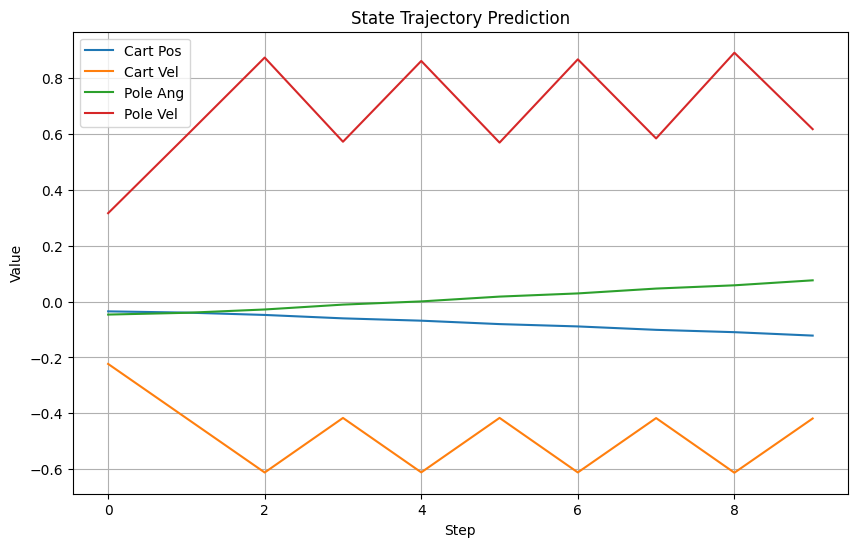

In [54]:
env = gym.make('CartPole-v1')
agent = BFS(num_simulations=100)


state = env.reset()[0]

action, root = agent.bfs_search(state)

visualize_action_sequence(root)